## EDM Toy Example

With this toy example we illustrate the training efficiency of using CEDM (Conditional Entropy in Diffusion Models). We first: 

1. Re-implemente EDM using torch lighetning and demostrate some equivalents to their vs SDE parameterizations.
2. Instead of sampling the noise levels using EDM heuristic samplers we sample from the conditional entropy.
3. Then, we propose our adaptive method.

### 1) DataLoader 

Loading Dataset...
Min-max normalizing data...


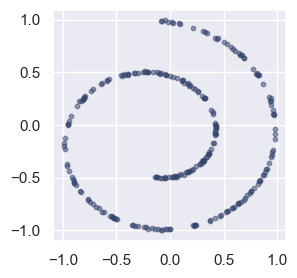

In [1]:
%load_ext autoreload
%autoreload 2

import torch 
import matplotlib.pyplot as plt
from datamodules.toy_datasets import ToyDataModule
from utils.plots import plot_2d_data

from training.losses import *
from training.noise_samplers.schedules import *
from training.noise_samplers.visualize import plot_sigma_distributions, plot_sigma_trajectories


device = "cuda" if torch.cuda.is_available() else "cpu"

print("Loading Dataset...")
toy_dm = ToyDataModule(dataset_name="swiss_roll", 
                       num_samples=10000,
                       noise=0.05,
                       batch_size=256, 
                       num_workers=0, 
                       min_max_normalize=True)
toy_dm.prepare_data()
toy_dm.setup()

# Get train dataloader
dataloader = toy_dm.train_dataloader()
x, _ = next(iter(dataloader))

# Plot toy data
plot_2d_data(x.numpy(), name="toy_data", figsize=(3, 3))

### 2) Noise Schedulers and equivalence with SDE formulation

Rather than using complex formulation, EDM proposed to separate its complexity by proposing a unified framework that consists on only looking at the Gaussian kernel,


\begin{equation}
    p_{0t}(\mathbf{x}_t ~|~ \mathbf{x}_0) = \mathcal{N} \big( \mathbf{x}_t; ~s(t) ~\mathbf{x}_0, ~s(t)^2 ~\sigma(t)^2 ~\mathbf{I} \big) 
\end{equation}

To define a general framework, rather than having a noisy state directly by reparameterizing the Gaussian kernel, everything is defined for the VESDE case, where $s(t) =1$. This allows to define a general way to noise data via 

\begin{equation}
    \mathbf{x}_t  = \mathbf{x}_0 + \sigma(t) * \epsilon 
\end{equation}

The equivalence from VE to VP is possible by scaling the function, in practice this is done by a preconditioning network. 

In [2]:
import hydra

if not hydra.core.global_hydra.GlobalHydra.instance().is_initialized():
    hydra.initialize(config_path="./config", version_base=None)
    cfg = hydra.compose(config_name="config")

print(cfg)

{'network': {'type': 'mlp', 'input_dim': 2, 'hidden_dim': 128, 'num_hidden_layers': 4, 'time_embedding_dim': 8}, 'model': {'type': 'edm', 'network': '${network}', 'edm': {'sigma_data': 0.5, 'sigma_min': 0.02, 'sigma_max': 100, 'rho': 7.0, 'P_mean': -1.2, 'P_std': 1.2}, 'vp': {'beta_d': 19.9, 'beta_min': 0.1, 'M': 1000, 'epsilon_t': 1e-05, 'sigma_data': 0.5}, 've': {'sigma_min': 0.02, 'sigma_max': 100.0, 'sigma_data': 0.5}, 'iddpm': {'C_1': 0.001, 'C_2': 0.008, 'M': 1000, 'sigma_data': 0.5}}, 'train': {'batch_size': 256, 'num_workers': 4, 'learning_rate': 0.001, 'max_epochs': 100, 'accelerator': 'auto', 'devices': 1, 'precision': 16, 'sampling_interval': 5}, 'dataset': {'name': 'swiss_roll', 'num_samples': 10000, 'noise': 0.05, 'min_max_normalize': True}, 'sampling': {'batch_size': 500, 'n_steps': 10, 'eval_samples': 1000, 'eval_batch_size': 100}, 'logging': {'save_dir': 'results', 'name': 'diffusion_experiment', 'version': '1', 'log_every_n_steps': 50, 'save_top_k': 3, 'monitor': 'val_

/home/gabriel/miniconda3/envs/entropy/lib/python3.9/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [3]:
config = {
    'model': {
        'input_dim': 2,
        'hidden_dim': 256,
        'num_hidden_layers': 6,
        'time_embedding_dim': 16
    },
    'preconditioning': {
        'enabled': True,
        'sigma_data': 0.5
    },
    'loss': {
        'type': 'edm',
        'P_mean': -1.2,
        'P_std': 1.2,
        'sigma_data': 0.5
    },
    'sampler': {
        'type': 'log_normal',
        'P_mean': -1.2,
        'P_std': 1.2
    }
}

loss_config = config["loss"]  # Get the loss_fn sub-config 
loss_config.get('type')


'edm'

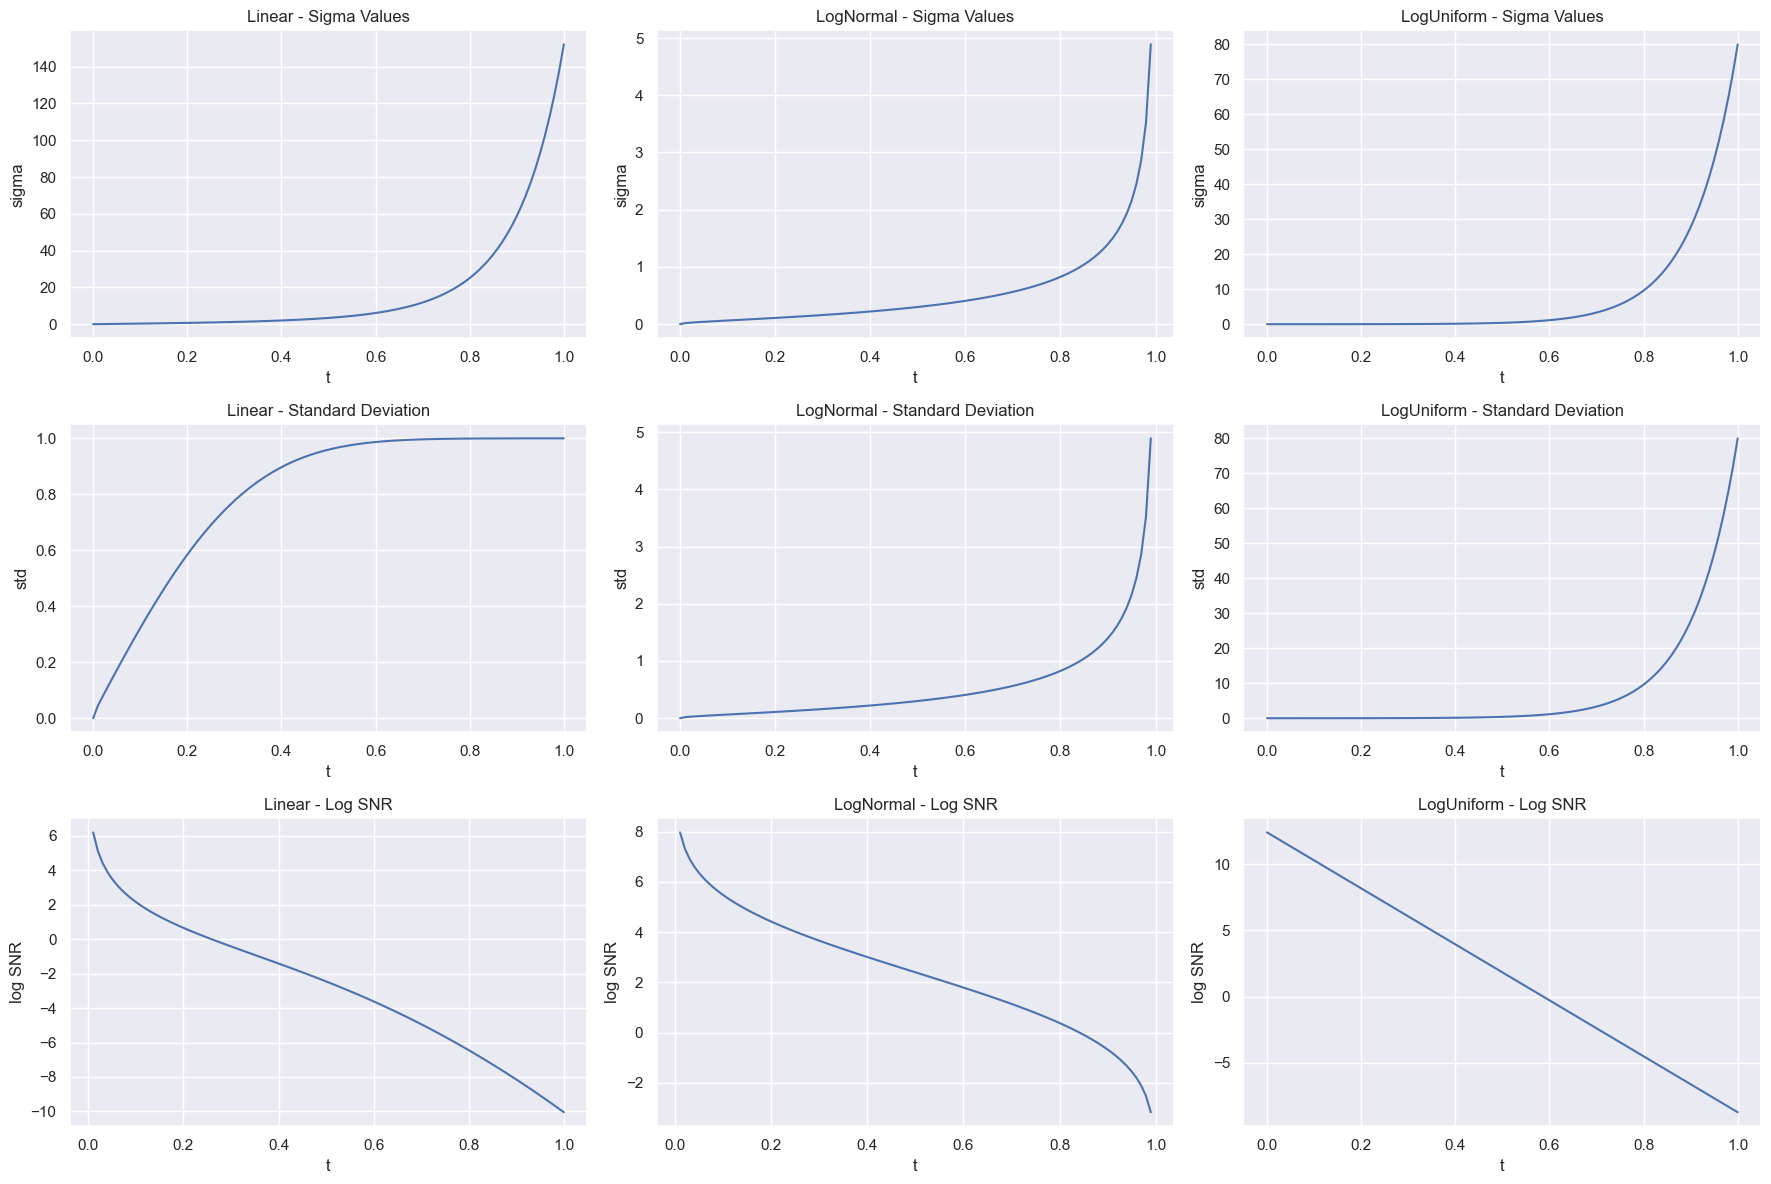

In [4]:
from training.noise_samplers.schedules import LinearNoiseSampler, LogNormalNoiseSampler, LogUniformNoiseSampler

# Create samplers for each type
samplers = {
    'Linear': LinearNoiseSampler(),
    'LogNormal': LogNormalNoiseSampler(),
    'LogUniform': LogUniformNoiseSampler()
}

# Create time points
t = torch.linspace(0, 1, 100)

# Create figure with subplots for each sampler
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

# Plot metrics for each sampler
for i, (name, sampler) in enumerate(samplers.items()):
    # Calculate metrics
    sigmas = sampler.sigma(t)
    s_t = sampler.signal(t)
    std = sigmas * s_t
    logsnr = sampler.logsnr(t)
    
    # Plot sigmas
    axes[0, i].plot(t, sigmas)
    axes[0, i].set_title(f'{name} - Sigma Values')
    axes[0, i].set_xlabel('t')
    axes[0, i].set_ylabel('sigma')
    
    # Plot standard deviation
    axes[1, i].plot(t, std)
    axes[1, i].set_title(f'{name} - Standard Deviation')
    axes[1, i].set_xlabel('t')
    axes[1, i].set_ylabel('std')
    
    # Plot log SNR
    axes[2, i].plot(t, logsnr)
    axes[2, i].set_title(f'{name} - Log SNR')
    axes[2, i].set_xlabel('t')
    axes[2, i].set_ylabel('log SNR')

plt.tight_layout()
plt.show()

In [5]:
# Visualize Forward Process : TODO

# from training.noise_samplers.visualize import plot_forward_process_animation

# # Animated visualization
# plot_forward_process_animation(
#     x, sigma_sampler,
#     num_steps=50,  # Number of frames in animation
#     title='Forward Process Animation: Cosine Sampler'
# )

In [6]:
# Get loss function
print(f"Running with loss type: {loss_config['type']}")

loss_fn = get_loss_fn(loss_config)

Running with loss type: edm


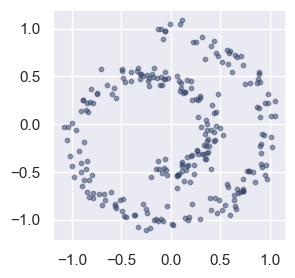

In [7]:
sigma_sampler = LogNormalNoiseSampler()

x = x.to(device)
t = 0.1 * torch.ones(x.shape[0], device=device)

noise = torch.randn_like(x)
sigmas = sigma_sampler.sigma(t)

noised_x = x + noise * sigmas.unsqueeze(-1)

plot_2d_data(noised_x.cpu().numpy(), name="noised_toy_data", figsize=(3, 3))

## Networks

The EDM formulation requires the construction of 2 networks: 

1. The noise prediction network (base model)
2. The Denoiser network using the EDM formulation

In [8]:
%load_ext autoreload
%autoreload 2
from networks.toy_network import MLP
from models.edm import EDM
from models.lightning.edm_lightning import EDMLightning
import lightning as L
from networks.preconditioning import EDMPrecond

# Configuration-based initialization
config ={
    'model': {
        'type': 'mlp',
        'hidden_dim': 64,
        'num_hidden_layers': 5,
        'time_embedding_dim': 8
    },
    'loss': {
        'type': 'edm',
        'P_mean': -1.2,
        'P_std': 1.2
    },
    'sampler': {
        'type': 'log_normal',
        'P_mean': -1.2,
        'P_std': 1.2
    },
    'precond': {
        'type': 'edm',
        'sigma_min': 0.01,
        'sigma_max': 100,
        'rho': 7.0,
        'sigma_data': 0.5
    },
    'train': {
        'learning_rate': 1e-3,
    }
}

# Base model 
base_model = MLP(input_dim=2,
                 hidden_dim=config['model']['hidden_dim'], 
                 num_hidden_layers=config['model']['num_hidden_layers'], 
                 time_embedding_dim=config['model']['time_embedding_dim'])

# Choose Preconditioning scheme
precond = EDMPrecond(sigma_data=config['precond']['sigma_data'],
                     sigma_min=config['precond']['sigma_min'],
                     sigma_max=config['precond']['sigma_max'])

model = EDM(base_model=base_model, precond=precond)

loss_fn = get_loss_fn(config['loss'])

model = EDMLightning(model=model, 
                     loss_fn=loss_fn,
                     config=config)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
trainer = L.Trainer(
                    max_epochs=2,
                    accelerator="gpu",
                    devices="auto",
)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [10]:
trainer.fit(model, toy_dm)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | EDM  | 21.6 K | train
---------------------------------------
21.6 K    Trainable params
0         Non-trainable params
21.6 K    Total params
0.087     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Min-max normalizing data...
Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/gabriel/miniconda3/envs/entropy/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


/home/gabriel/miniconda3/envs/entropy/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/gabriel/miniconda3/envs/entropy/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 1: 100%|██████████| 32/32 [00:00<00:00, 68.21it/s, v_num=1, train_loss_step=1.100, val_loss=1.120, train_loss_epoch=1.100]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 32/32 [00:00<00:00, 66.84it/s, v_num=1, train_loss_step=1.100, val_loss=1.120, train_loss_epoch=1.100]


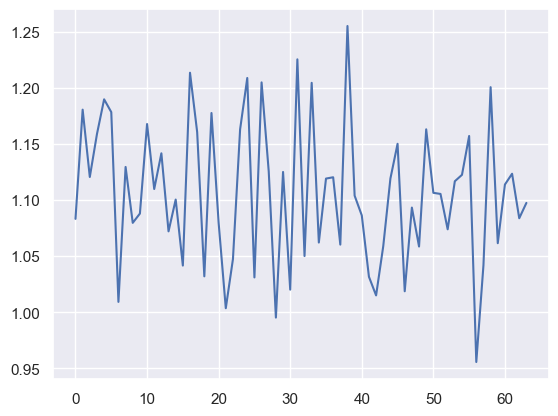

In [11]:
plt.plot(model.train_loss)

In [12]:
denoiser = model.model.eval()

In [13]:
from inference import KarrasDiffEq, KarrasHeun2Solver,KarrasNoiseSchedule
from inference import sample_trajectory_batch

# Create ODE and solver
ode = KarrasDiffEq(denoiser)
solver = KarrasHeun2Solver()

# sampling noise schedule
noise_schedule = KarrasNoiseSchedule(
    sigma_data=config['precond']['sigma_data'],
    sigma_min=config['precond']['sigma_min'],
    sigma_max=config['precond']['sigma_max'],
    rho=config['precond']['rho']
)


In [14]:
# Generate samples
samples = sample_trajectory_batch(
    input_shape=(2,),
    ode=ode,
    solver=solver,
    noise_schedule=noise_schedule,
    batch_size=500,
    n_steps=50,
    device=device
)

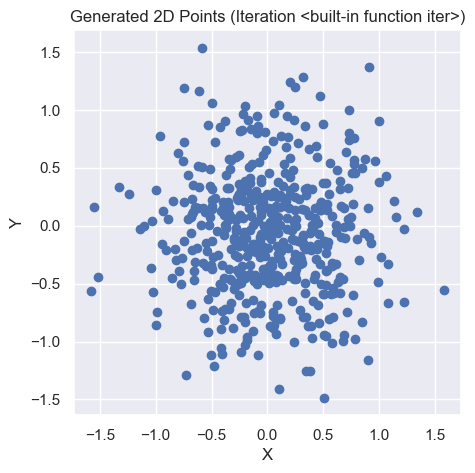

In [15]:
# Plot final samples
plt.figure(figsize=(5, 5))
final_samples = samples[-1].detach().cpu().numpy()
plt.scatter(final_samples[:, 0], final_samples[:, 1])
plt.title(f"Generated 2D Points (Iteration {iter})")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)

In [18]:
fuckers

NameError: name 'fuckers' is not defined

In [16]:



x = x.to(device)
t = 0.1 * torch.ones(x.shape[0], device=device)

noise = torch.randn_like(x)
sigmas = sigma_sampler.sigma(t)

In [17]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

for epoch in range(100):
    for batch in dataloader:
        x, _ = batch
        loss = net.get_loss(x, None)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

NameError: name 'net' is not defined

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | EDM  | 17.5 K | train
---------------------------------------
17.5 K    Trainable params
0         Non-trainable params
17.5 K    Total params
0.070     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Min-max normalizing data...
Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 101.74it/s]Debug: t shape torch.Size([256, 1]) x shape torch.Size([256, 2])
                                                                            

/home/gabriel/miniconda3/envs/entropy/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/gabriel/miniconda3/envs/entropy/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/gabriel/miniconda3/envs/entropy/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 32/32 [00:00<00:00, 121.19it/s, v_num=9, train_loss_step=1.180]Debug: t shape torch.Size([256, 1]) x shape torch.Size([256, 2])
Debug: t shape torch.Size([256, 1]) x shape torch.Size([256, 2])
Debug: t shape torch.Size([256, 1]) x shape torch.Size([256, 2])
Debug: t shape torch.Size([256, 1]) x shape torch.Size([256, 2])
Debug: t shape torch.Size([256, 1]) x shape torch.Size([256, 2])
Debug: t shape torch.Size([256, 1]) x shape torch.Size([256, 2])
Debug: t shape torch.Size([256, 1]) x shape torch.Size([256, 2])
Debug: t shape torch.Size([208, 1]) x shape torch.Size([208, 2])
Epoch 1: 100%|██████████| 32/32 [00:00<00:00, 115.92it/s, v_num=9, train_loss_step=1.030, val_loss=1.090, train_loss_epoch=1.120]Debug: t shape torch.Size([256, 1]) x shape torch.Size([256, 2])
Debug: t shape torch.Size([256, 1]) x shape torch.Size([256, 2])
Debug: t shape torch.Size([256, 1]) x shape torch.Size([256, 2])
Debug: t shape torch.Size([256, 1]) x shape torch.Size([256, 2])
De

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 90.64it/s, v_num=9, train_loss_step=1.180, val_loss=1.080, train_loss_epoch=1.080]


In [ ]:
epochs = 100

for epoch in range(epochs):
    for batch in dataloader:
        x, _ = batch
        t = torch.rand(x.shape[0])
        t = t.unsqueeze(-1)
        x_noised = toy_dm.noise_fn(x, t)

tensor([0.4746, 0.2783, 0.8378, 0.9885, 0.0248])